Для запуска необходимо иметь веру в бога

## 0. Imports + Compile DISORT

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from misc_functions import *

In [2]:
# must be 1.26.4
if np.__version__ != '1.26.4':
    !pip install numpy==1.26.4

In [3]:
np.__version__

'1.26.4'

In [4]:
!gcc --version
!gfortran --version

# must be 3.11.9
!python --version

gcc (MinGW-W64 x86_64-ucrt-posix-seh, built by Brecht Sanders, r3) 14.1.0
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

GNU Fortran (MinGW-W64 x86_64-ucrt-posix-seh, built by Brecht Sanders, r3) 14.1.0
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Python 3.12.4


In [5]:
# !f2py -c src/DRIVER.f\
# src/BDREF.f src/DISOBRDF.f \
# src/DISOTESTAUX.f src/DISORT.f \
# src/ERRPACK.f \
# src/LAPACK.f  src/LINPAK.f \
# src/RDI1MACH.f \
# -m disort 

# --verbose
# --quiet

In [6]:
# !del *.dll

In [7]:
# !move disort\.libs\*.dll 

## 1. Inputs

### 1.1 Hyperparameters 

In [3]:
# Коррекция верхней границы облаков
dhrange = np.arange(0, -12, -2)  # создаем массив от 0 до -10 с шагом -2
dh = dhrange[0]  # выбираем первое значение из массива

sf = 2.0  # коэффициент масштабирования облачных аэрозолей

hmin = 0 # [-3:10]
emis = 0.95
emis_ang = 0
ic = 0.3
Loshmidt = 2.69e19
# for sf in np.arange(2.4, 0.3, -0.4):  # цикл для sf (2.4, 2.0, 1.6, 1.2, 0.8, 0.4)
# for hmin in range(-2, 11):  # цикл для hmin (-2 до 10)

### 1.2 Set up directories

In [4]:
GAS_EXT_PATH = 'gas_ext/'
GAS_EXT_FILE = 'gas_ext_CO2_hot_ames_H2O_HDO_hitran_bezard_005_9600_11000_104.csv'

PROFILE_FILENAME = 'VIRAPROFILE.txt'
AEROSOL_FILENAME = 'venusclouds_75_Haus16.txt'

LINES_PATH = 'databases/'
INPUT_PATH = 'input/'

CORE_NAME = GAS_EXT_FILE[8:-4]
SF = str(sf).replace('.', '_')
IC = str(ic).replace('.', '_')

OUTPUT_PATH = f'disort_output/{CORE_NAME}/'
OUTPUT_FILENAME = f'disort_result_emis_{emis}_ang_{emis_ang}_hmin_{hmin}_sf_{SF}_ic_{IC}_{CORE_NAME}.csv'

In [5]:
CORE_NAME

'CO2_hot_ames_H2O_HDO_hitran_bezard_005_9600_11000_104'

In [6]:
os.makedirs(OUTPUT_PATH, exist_ok=True)

## 2. Profile of the atmoshpere

In [7]:
pressure, height, concentration, temperature = np.loadtxt(INPUT_PATH + PROFILE_FILENAME, skiprows = 1, unpack=True)

height_corrected = np.arange(hmin, 101, 1)
pressure_corrected = np.exp(interp1d(height, np.log(pressure), kind='linear', fill_value='extrapolate')(height_corrected))
concentration_corrected = np.exp(interp1d(height, np.log(concentration), kind='linear', fill_value='extrapolate')(height_corrected))
temperature_corrected = interp1d(height, temperature, kind='linear', fill_value='extrapolate')(height_corrected)

atm = np.column_stack([
    pressure_corrected, 
    height_corrected, 
    concentration_corrected, 
    temperature_corrected
])

In [8]:
temperature_corrected

array([735.3 , 727.7 , 720.2 , 712.4 , 704.6 , 696.8 , 688.8 , 681.1 ,
       673.6 , 665.8 , 658.2 , 650.6 , 643.2 , 635.5 , 628.1 , 620.8 ,
       613.3 , 605.2 , 597.1 , 589.3 , 580.7 , 572.4 , 564.3 , 556.  ,
       547.5 , 539.2 , 530.7 , 522.3 , 512.8 , 505.6 , 496.9 , 488.3 ,
       479.9 , 471.7 , 463.4 , 455.5 , 448.  , 439.9 , 432.5 , 425.1 ,
       417.6 , 410.  , 403.5 , 397.1 , 391.2 , 385.4 , 379.7 , 373.1 ,
       366.4 , 358.6 , 350.5 , 342.  , 333.3 , 323.  , 312.8 , 302.3 ,
       291.8 , 282.5 , 275.2 , 268.7 , 262.8 , 258.65, 254.5 , 249.95,
       245.4 , 243.2 , 241.  , 238.2 , 235.4 , 232.6 , 229.8 , 226.95,
       224.1 , 221.35, 218.6 , 215.35, 212.1 , 208.7 , 205.3 , 201.2 ,
       197.1 , 193.5 , 189.9 , 186.85, 183.8 , 181.  , 178.2 , 175.9 ,
       173.6 , 171.5 , 169.4 , 168.3 , 167.2 , 167.2 , 167.2 , 168.2 ,
       169.2 , 170.6 , 172.  , 173.7 , 175.4 ])

## 3. Read gas exctinction file

In [9]:
gas_abs_data = pd.read_csv(GAS_EXT_PATH + GAS_EXT_FILE, header=None)
gas_abs_data = np.array(gas_abs_data)

In [10]:
# np.where(gas_abs_data<0)

In [11]:
gas_ext = gas_abs_data[1:]
wavenum = gas_abs_data[0]
wavenum

array([ 9600.        ,  9600.05      ,  9600.1       , ...,
       10999.89999998, 10999.94999998, 10999.99999998])

In [12]:
1e4/wavenum

array([1.04166667, 1.04166124, 1.04165582, ..., 0.90909917, 0.90909504,
       0.90909091])

In [26]:
gas_ext[hmin+3:].shape

(101, 28001)

In [27]:
gas_ext = gas_ext[hmin+3:]
# gas_ext = interp1d(height, gas_ext, kind='linear', fill_value='extrapolate', axis=0)(height_corrected)

In [28]:
gas_ext.shape

(101, 28001)

In [51]:
gas_ext = (gas_ext.T + ic * 1e-9/Loshmidt**2 * atm[:, 2]**2).T

## 4. Compute aerosol scattering & absorption

In [53]:
# Оптические свойства аэрозолей
data = np.loadtxt(INPUT_PATH + AEROSOL_FILENAME)

# Расчет рассеяния и поглощения аэрозолей
modeH = [1, 21, 22, 3]
aer_wavenum = data[::4, 0]
wavelen = data[::4, 1]

modes = data[:, 2].reshape(len(aer_wavenum), 4).T
Cext = data[:, 3].reshape(len(aer_wavenum), 4)
Csca = data[:, 6].reshape(len(aer_wavenum), 4)

Galb = data[:, 4].reshape(len(aer_wavenum), 4)
Gass = data[:, 5].reshape(len(aer_wavenum), 4)


nphi = 51
nL = 101
MILC = data[:, 7 + nphi * 2:].reshape(len(aer_wavenum), 4, nL)
mileg = np.zeros((4, nL, len(aer_wavenum)))


for i in range(4):
    mileg[:, :, i] = MILC[i, :, :]

zb = np.array([49, 65, 49, 49])
zb[:2] += dh
zc = np.array([16, 1, 11, 8])
N0 = np.array([193.5, 100, 50, 14])
N0[1:] *= sf
Hup = np.array([3.5, 3.5, 1.0, 1.0])
Hlo = np.array([1.0, 3.0, 0.1, 0.5])

N = np.zeros((len(atm[:, 1]), 4))

for i in range(4):
    idx1 = atm[:, 1] > (zb[i] + zc[i])
    idx2 = (atm[:, 1] <= (zb[i] + zc[i])) & (atm[:, 1] >= zb[i])
    idx3 = atm[:, 1] < zb[i]
    
    N[idx1, i] = N0[i] * np.exp(-(atm[idx1, 1] - (zb[i] + zc[i])) / Hup[i])
    N[idx2, i] = N0[i]
    N[idx3, i] = N0[i] * np.exp(-(zb[i] - atm[idx3, 1]) / Hlo[i])

aer_ext = np.dot(Cext, N.T) / 1000  # Cext [micron^2] * N [1/cm^3] * 10^(-3) --> km^(-1)
aer_sca = np.dot(Csca, N.T) / 1000

aer_ext = aer_ext.T
aer_sca = aer_sca.T

gfmat = Gass

scamat = np.zeros((len(wavelen), len(atm[:, 1]), 4))
for i in range(4):
    scamat[:, :, i] = np.dot(Csca[:, i].reshape(-1, 1), N[:, i].reshape(1, -1)) / 1000

aer_ssalb = aer_sca / aer_ext
aer_ssalb[aer_ext <= 0] = 0

In [54]:
# Вычисление длины волны
lambda_vals = 1e4 / wavenum

# Инициализация массива для рассеяния Рэлея
rayleigh = np.zeros((len(atm[:, 2]), len(wavenum)))

# Цикл для вычисления рассеяния Рэлея для каждого значения в атмосфере
for i in range(len(atm[:, 1])):
    mus = (6.99100e-2 / (166.175000 - lambda_vals**(-2)) +
           1.44720e-3 / (79.609000 - lambda_vals**(-2)) +
           6.42941e-5 / (56.306400 - lambda_vals**(-2)) +
           5.21306e-5 / (46.019600 - lambda_vals**(-2)) +
           1.46847e-6 / (0.0584738 - lambda_vals**(-2)))
    
    n = 1 + mus * atm[i, 0] / atm[i, 3] * 273.15 / 1.01325
    
    rayleigh[i, :] = (24 * np.pi**3 / (lambda_vals * 1e-4)**4 / atm[i, 2]**2 *
                      ((n**2 - 1) / (n**2 + 2))**2 *
                      (1.1364 + 25.3e-4 / lambda_vals**2) * atm[i, 2])

# Преобразование единиц
rayleigh *= 1e5

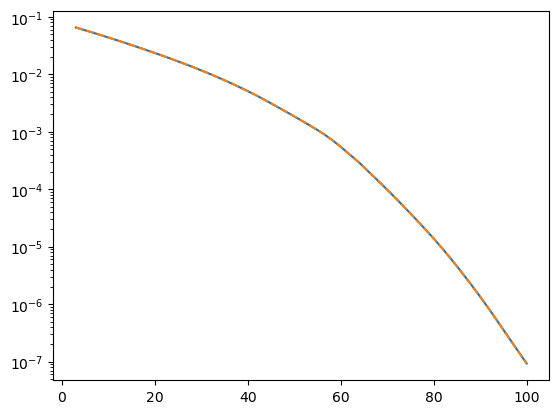

In [55]:
plt.yscale('log')
plt.plot(atm[:, 1], rayleigh[:, 0])
plt.plot(atm[:, 1], rayleigh_1[:, 0], '--')

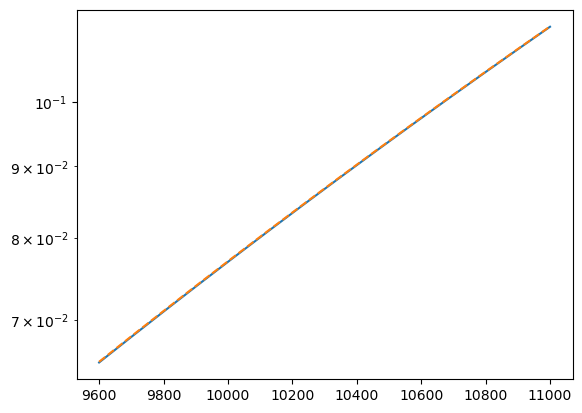

In [56]:
plt.yscale('log')
plt.plot(wavenum, rayleigh[0, :])
plt.plot(wavenum, rayleigh_1[0, :], '--')

## 5. Параметры RTM

In [57]:
SFCTEMP = atm[0, 3]

ZZ = atm[::-1, 1]
TT = atm[::-1, 3]
delta_zz = 1 #np.abs(np.diff(ZZ))

GF = np.zeros_like(gas_ext)  # текущий геометрический фактор уровня

# LEGW = np.zeros((len(aer_wavenum), len(ZZ), 5))  # Весовые коэффициенты Лежандра
# MLEG = np.zeros((nL, len(aer_wavenum), 5))  # Коэффициенты Лежандра MI

# MLEG[0, :, :] = 1
# MLEG[2, :, 4] = 0.1
# for iL in range(1, nL):
#     for im in range(4):
#         MLEG[iL, :, im] = interp1d(aer_wavenum, mileg[:, iL, im], kind='linear', fill_value='extrapolate')(wavenum)


aer_ext_interp = interp1d(aer_wavenum, aer_ext, axis=1, kind='linear', fill_value='extrapolate')(wavenum)
aer_sca_interp = interp1d(aer_wavenum, aer_sca, axis=1, kind='linear', fill_value='extrapolate')(wavenum)

TAUCL = gas_ext + aer_ext_interp + rayleigh  # текущий уровень экстинкции
SCACL = aer_sca_interp + rayleigh        # текущий уровень рассеяния
TAUCL = TAUCL[::-1, :]                # однократное рассеяние (однородное поглощение)
SCACL = SCACL[::-1, :]
SSALB = SCACL / TAUCL

for i in range(len(ZZ)-1, -1, -1):
    i1 = len(ZZ) - i - 1

    GF[i1,:] = (interp1d(aer_wavenum, gfmat[:, 0] * scamat[:, i, 0], kind='linear', fill_value='extrapolate')(wavenum) +
                 interp1d(aer_wavenum, gfmat[:, 1] * scamat[:, i, 1], kind='linear', fill_value='extrapolate')(wavenum) +
                 interp1d(aer_wavenum, gfmat[:, 2] * scamat[:, i, 2], kind='linear', fill_value='extrapolate')(wavenum) +
                 interp1d(aer_wavenum, gfmat[:, 3] * scamat[:, i, 3], kind='linear', fill_value='extrapolate')(wavenum))  / SCACL[i1,:]
    # for im in range(4):
    #     LEGW[:, i1, im] = interp1d(aer_wavenum, scamat[:, i, im], kind='linear', fill_value='extrapolate')(wavenum)
    # LEGW[:, i1, 4] = rayleigh[i, :]

TAUSUM = (TAUCL[:-1, :] + TAUCL[1:, :]) / 2 #* np.repeat(delta_zz[np.newaxis, :], len(aer_wavenum), axis=0).T
SCASUM = (SCACL[:-1, :] + SCACL[1:, :]) / 2 #* np.repeat(delta_zz[np.newaxis, :], len(aer_wavenum), axis=0).T
# LEGW = (LEGW[:, :-1, :] + LEGW[:, 1:, :]) / 2 * np.repeat(delta_zz[np.newaxis, :, np.newaxis], len(aer_wavenum), axis=0)
# for im in range(5):
#     LEGW[:, :, im] = LEGW[:, :, im] / SCASUM.T
SSALB = (SSALB[:-1, :] + SSALB[1:, :]) / 2
GF = (GF[:-1, :] + GF[1:, :]) / 2

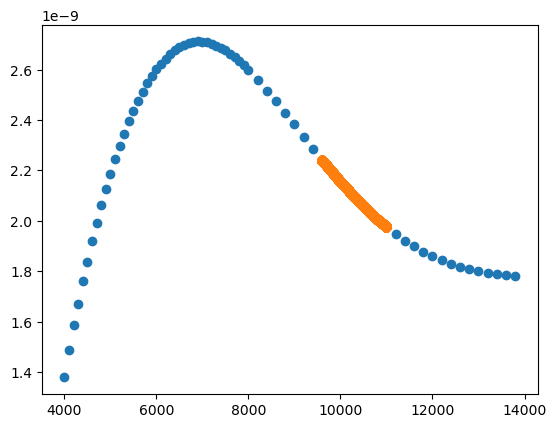

In [58]:
plt.scatter(aer_wavenum, aer_ext[0, :])
plt.scatter(wavenum, aer_ext_interp[0, :])

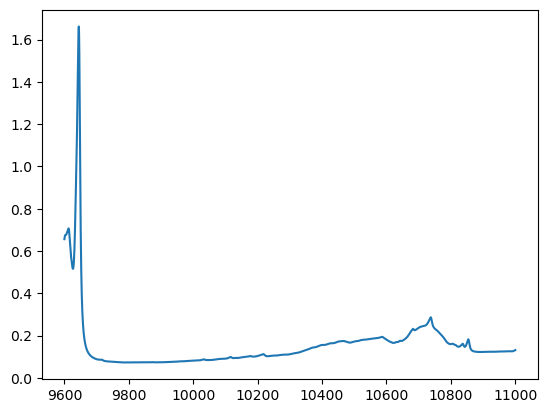

In [59]:
plt.plot(wavenum, TAUSUM[-1, :])

In [60]:
moo=0

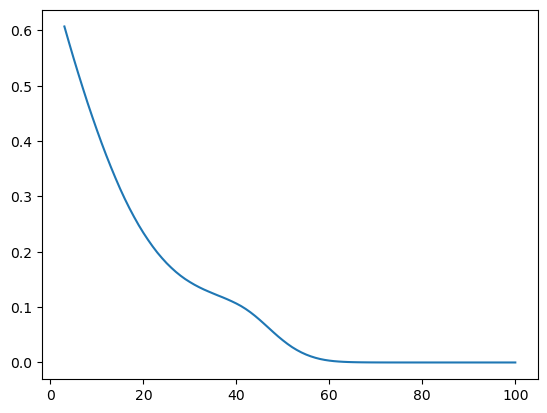

In [61]:
plt.plot(atm[:, 1], gas_ext[:, moo])

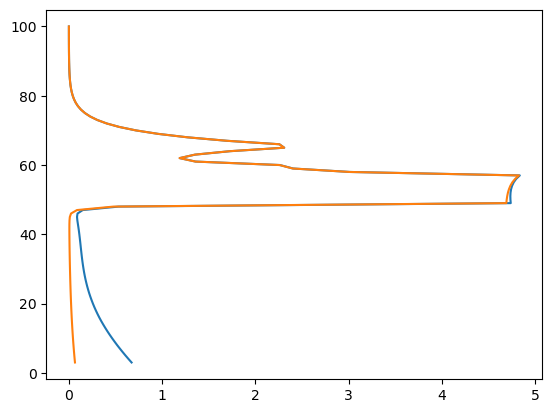

In [62]:
plt.plot(TAUCL[:, moo], ZZ)
plt.plot(SCACL[:, moo], ZZ)

In [63]:
np.where(SSALB>1)
# SSALB[2]

(array([], dtype=int64), array([], dtype=int64))

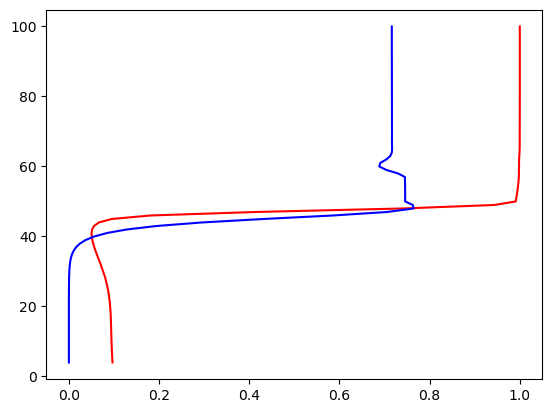

In [64]:
plt.plot(SSALB[:, moo], ZZ[:-1], color='r')
plt.plot(GF[:, moo], ZZ[:-1], color='b')

In [65]:
import disort

In [83]:
180/np.pi*np.arccos([-1.0, -0.9848, -0.9397, -0.8660, -0.7660, -0.6428, -0.5, 
       -0.3420, -0.1736, -0.0872, -.01, .01,  0.0872, 0.1736,
       0.3420,  0.5,  0.6428,  0.7660,  0.8660,  0.9397,  0.9848, 1.0])

array([180.        , 169.99744219, 160.00123621, 149.99708907,
       139.99603866, 130.00092673, 120.        , 109.99877181,
        99.99719705,  95.00254544,  90.57296734,  89.42703266,
        84.99745456,  80.00280295,  70.00122819,  60.        ,
        49.99907327,  40.00396134,  30.00291093,  19.99876379,
        10.00255781,   0.        ])

In [67]:
NLYR = len(ZZ)-1

UMU = [np.cos(emis_ang)]

# UMU = [-1.0, -0.9848, -0.9397, -0.8660, -0.7660, -0.6428, -0.5, 
#        -0.3420, -0.1736, -0.0872, -.01, .01,  0.0872, 0.1736,
#        0.3420,  0.5,  0.6428,  0.7660,  0.8660,  0.9397,  0.9848, 1.0]

# UMU = np.array([-1.,-0.5,0.5,1.])

PHI0 = 0
PHI = [0]

UMU0 = 1
FISOT = 0.0

IBCND = 0
FBEAM = 0

SFCEMIS = emis # эмиссионная способность поверхности
LAMBER = True
ALBEDO = 1. - SFCEMIS
PLANK = True
TTEMP = 0.
TEMIS = 1.0

ONLYFL = False
USRTAU = False
USRANG = True
PRNT = np.array([False, False, False, False, False])
# PRNT = np.array([True, True, True, True, True])

NSTR = 16 # 32
MAXMOM = 299
MAXCLY = NLYR
MAXUMU = len(UMU)
MAXPHI = len(PHI)
MAXULV = NLYR + 1

ACCUR = 0

IPHAS = [3]*NLYR
# GG =  np.ones(NLYR)*0.85
UTAU = np.zeros(NLYR+1)

EARTH_RADIUS = 6052.1
DO_PSEUDO_SPHERE = True
DELTAMPLUS = True

H_LYR = ZZ #(ZZ[:-1] + ZZ[1:]) / 2
# WVNMLO = 9400
# WVNMHI = 11000

In [68]:
uu_ = []

for i, w_iter in enumerate(wavenum):
    [rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed, rhoq, rhou, rho_a, bemst, emust] =\
                                disort.run(dtauc=TAUSUM[:,i], ssalb=SSALB[:,i], iphas=IPHAS, gg=GF[:,i],
                                            umu0=UMU0, phi0=PHI0, albedo=ALBEDO, fbeam=FBEAM,
                                            usrtau=USRTAU, utau=UTAU, usrang=USRANG, umu=UMU,
                                            phi=PHI, nstr=NSTR, maxmom=MAXMOM, lamber=LAMBER,
                                            onlyfl=ONLYFL, accur=ACCUR, plank=PLANK,
                                            temper=TT, wvnmlo=w_iter, wvnmhi=w_iter,
                                            ibcnd=IBCND, fisot=FISOT, btemp=SFCTEMP, ttemp=TTEMP,
                                            temis=TEMIS, prnt=PRNT, earth_radius=EARTH_RADIUS, 
                                            h_lyr=H_LYR, deltamplus=DELTAMPLUS, 
                                            do_pseudo_sphere=DO_PSEUDO_SPHERE)
    uu_.append(uu)

uu_ = np.array(uu_)

output = np.vstack((wavenum, uu_[:, :, 0, 0].T)) 

#          [wavenum]
# UMU[0]   [intensity]
# UMU[1]   [intensity]
# ...
# UMU[-1]  [intensity]

np.savetxt(OUTPUT_PATH + OUTPUT_FILENAME, output, delimiter=',')

In [69]:
OUTPUT_PATH + OUTPUT_FILENAME

'disort_output/CO2_hot_ames_H2O_HDO_hitran_005_9600_11000/disort_result_emis_0.95_ang_0_hmin_3_sf_2_0_ic_0_3_CO2_hot_ames_H2O_HDO_hitran_005_9600_11000.csv'

In [70]:
disort_data = pd.read_csv(OUTPUT_PATH + OUTPUT_FILENAME, header=None)
disort_data = np.array(disort_data)

In [71]:
wavenum = disort_data[0]
disort_spectra = disort_data[1:]

In [77]:
uu_[:, 0, 0, 0]

1.9088604e-10

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


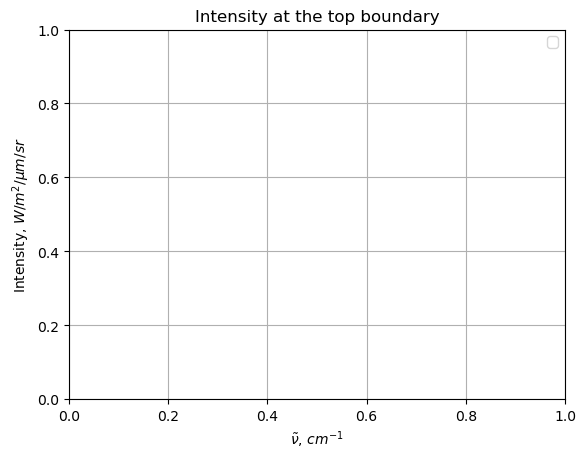

In [72]:
plot_for_selected_height(disort_spectra, wavenum, UMU)

In [79]:
df = pd.read_table('input/disort_result_cont000_02voigt_250_0202voigt_180_FL04_H2O_0_emi_95.txt', sep='\s+', header=None) 

In [80]:
df1 = pd.read_table('input/disort_result_cont000_02voigt_250_0605voigt_180_FL04_H2O_28_emi.txt', sep='\s+', header=None) 

In [81]:
df2 = pd.read_table('input/disort_result_cont000_09voigt_250_0202voigt_180_FL04_H2O_28_emi.txt', sep='\s+', header=None) 

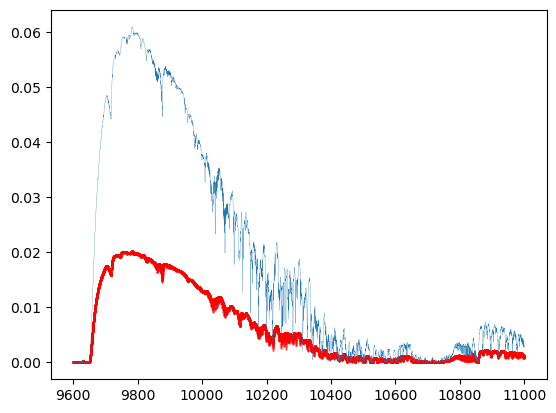

In [82]:
# ply.yscale('log')
plt.plot(df2[0], df2[11], linewidth=0.2)
plt.scatter(wavenum, disort_spectra[-1]*wavenum**2/1e4, s=0.2, c='r')